# Laplacian of Gaussian
---

In [1]:
from skimage.segmentation import slic
slic?

Signature:
slic(
    image,
    n_segments=100,
    compactness=10.0,
    max_iter=10,
    sigma=0,
    spacing=None,
    multichannel=True,
    convert2lab=None,
    enforce_connectivity=True,
    min_size_factor=0.5,
    max_size_factor=3,
    slic_zero=False,
)
Docstring:
Segments image using k-means clustering in Color-(x,y,z) space.

Parameters
----------
image : 2D, 3D or 4D ndarray
    Input image, which can be 2D or 3D, and grayscale or multichannel
    (see `multichannel` parameter).
n_segments : int, optional
    The (approximate) number of labels in the segmented output image.
compactness : float, optional
    Balances color proximity and space proximity. Higher values give
    more weight to space proximity, making superpixel shapes more
    square/cubic. In SLICO mode, this is the initial compactness.
    This parameter depends strongly on image contrast and on the
    shapes of objects in the image. We recommend exploring possible
    values on a log scale, e.g., 0.01, 0.

In [2]:
from itertools import product

import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from shapely.geometry import polygon, box
import matplotlib.pyplot as plt
plt.set_cmap('magma'); plt.close()

from skimage.measure import regionprops
from skimage.feature import canny, blob_log
from skimage.filters import threshold_otsu, sobel
from skimage.measure import label
from skimage.segmentation import (clear_border, felzenszwalb, watershed,
                                  mark_boundaries, join_segmentations)
from skimage.color import hed_from_rgb, grey2rgb

import secdetect

## Process overview image
---

In [3]:
# Load random overview image from `secdetect.data`
imin = secdetect.data.load(12)
imec = secdetect.enhance_contrast(imin, channel=2, conv_matrix=hed_from_rgb)
imcn = canny(imec, sigma=4, low_threshold=0.10, high_threshold=0.99, use_quantiles=True)
cx, cy, r = secdetect.find_ring(imcn)
imcr = secdetect.crop_to_ring(imin, cx=cx, cy=cy, radius=r)
imeccr = secdetect.crop_to_ring(imec, cx=cx, cy=cy, radius=r)

# Mask with Felzenszwalb segmentation
imfz = felzenszwalb(imcr, scale=750, sigma=1, min_size=500, multichannel=True)
imcb = clear_border(imfz, buffer_size=50)
mask = imcb > 0
mask_rgb = grey2rgb(mask)

masked_grey = np.where(mask, imeccr, 0)
masked_rgb = np.where(mask_rgb, imcr, 0)

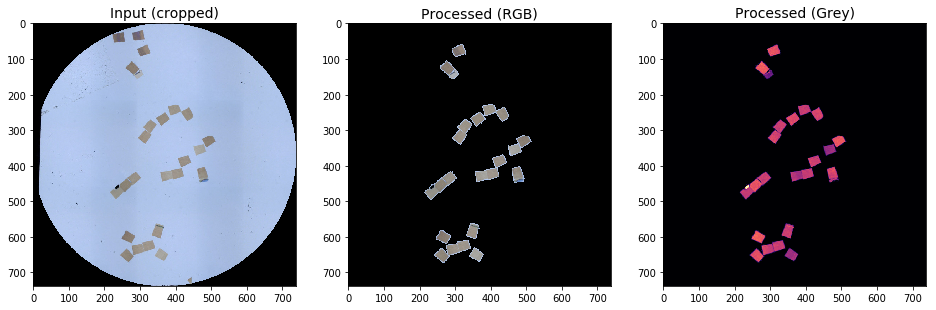

In [4]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 5))
axes[0].imshow(imcr)
axes[1].imshow(masked_rgb)
axes[2].imshow(masked_grey)
axes[0].set_title('Input (cropped)', fontsize=14)
axes[1].set_title('Processed (RGB)', fontsize=14)
axes[2].set_title('Processed (Grey)', fontsize=14);

## Iterate through parameter space
---

In [5]:
def product_dict(**kwargs):
    keys = kwargs.keys()
    vals = kwargs.values()
    for instance in product(*vals):
        yield dict(zip(keys, instance))

In [6]:
SLIC_param_set = {
    'n_segments': [100, 200, 500],
    'compactness': [5, 10, 20],
    'max_iter': [10],
    'sigma': [1],
    'spacing': [None],
    'multichannel': [True],
    'convert2lab': [None],
    'enforce_connectivity': [True, False],
    'min_size_factor': [0.5],
    'max_size_factor': [3],
    'slic_zero': [False]
}

SLIC_param_space = list(product_dict(**SLIC_param_set))

print(f'{len(SLIC_param_space)} permutations')

18 permutations


In [7]:
columns = list(SLIC_param_set.keys())
df = pd.DataFrame(columns=columns)

i = 0
segments = []
for SLIC_params in tqdm_notebook(SLIC_param_space):
    
    # Run SLIC
    segs = slic(imcr, **SLIC_params)
    segments.append(segs)
    
    # Build up DataFrame
    df = df.append(pd.DataFrame(SLIC_params, index=[i]), sort=True)
    
    # Increment index
    i += 1

# Preview DataFrame
var_cols = [k for k, v in SLIC_param_set.items() if len(v) > 1]
df[var_cols].sample(5)

,n_segments,compactness,enforce_connectivity
4,100,20,True
16,500,20,True
14,500,10,True
8,200,10,True
2,100,10,True


## Analysis
---

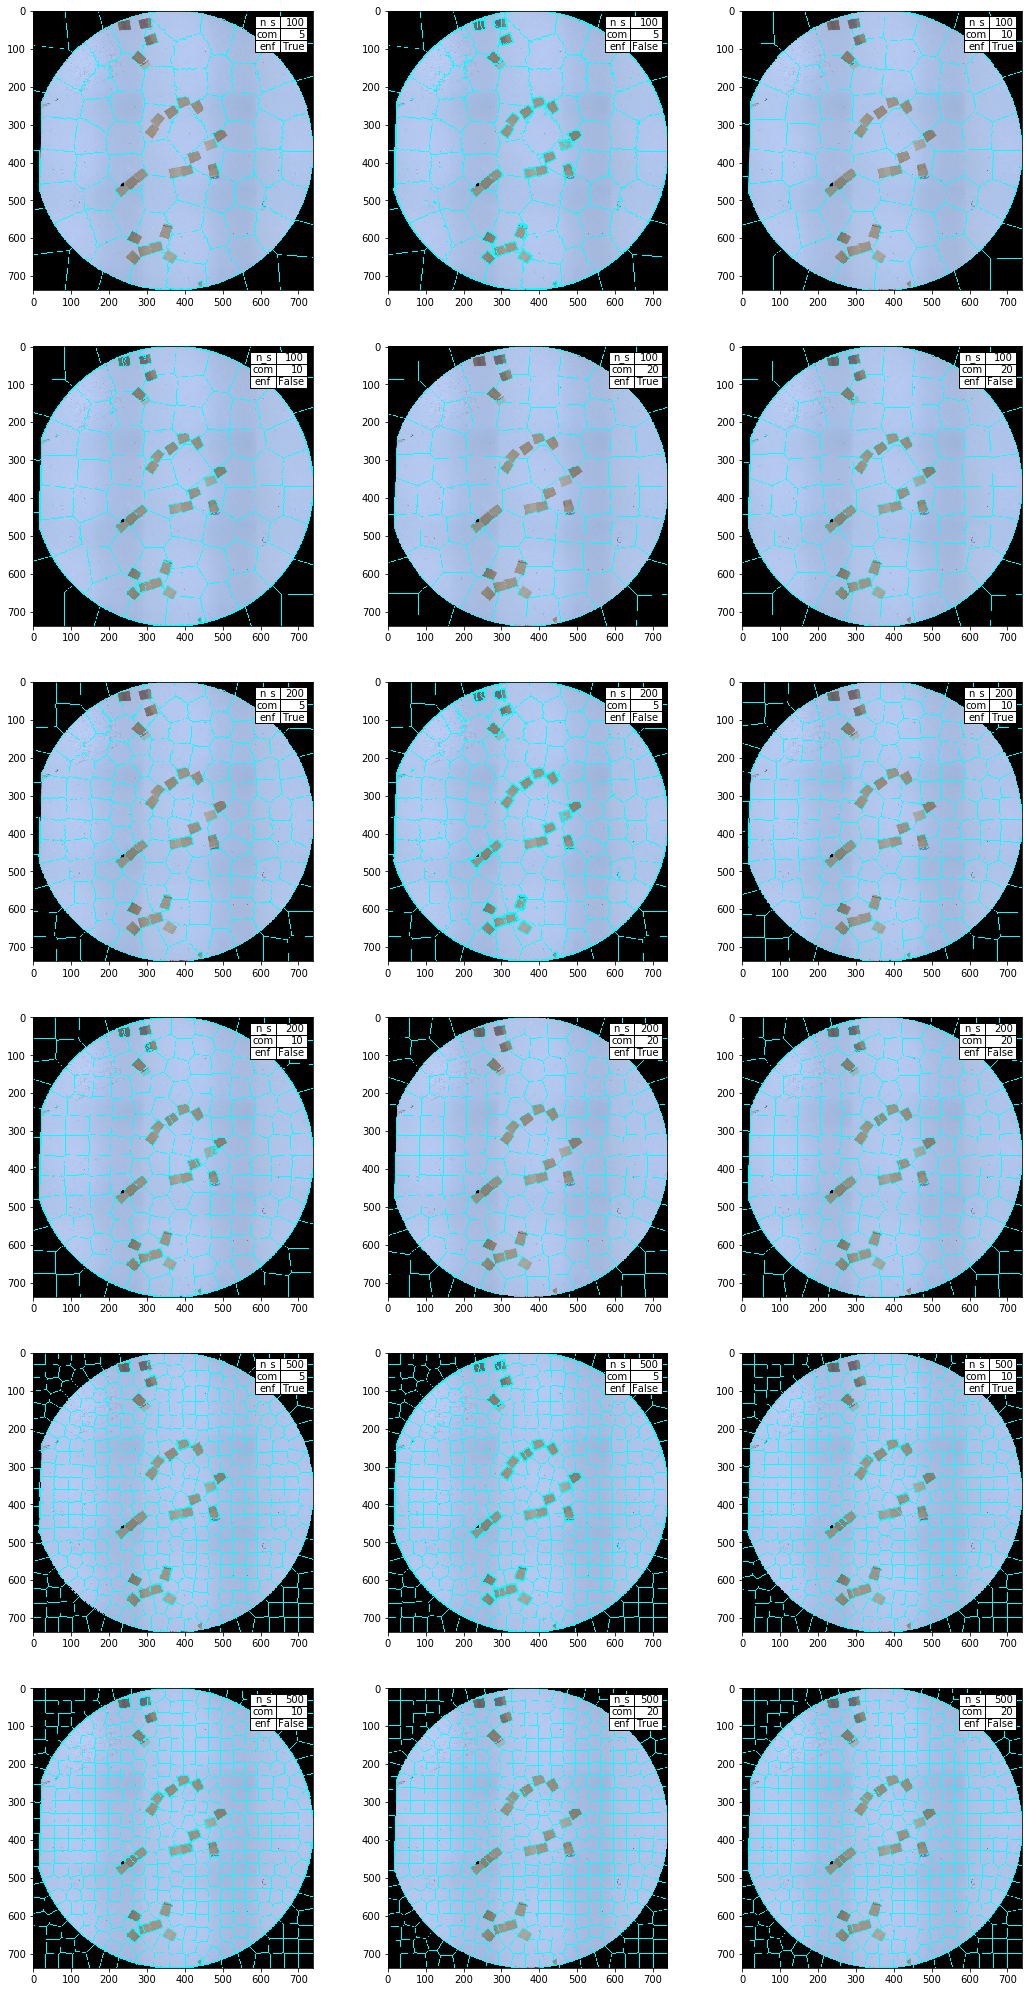

In [8]:
ncols = 3
nrows = int(np.ceil(len(df) / ncols))
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols, 6*nrows))
axes = axes.ravel()

for i, row in df.iterrows():
    
    # Plot image
    labels = segments[i]
    im_boundary = mark_boundaries(imcr, labels,
                                  color=(0, 1, 1))
    axes[i].imshow(im_boundary)
    
    # Make table
    vals = row[var_cols].values[:, np.newaxis]
    cols = [col[:3] for col in row[var_cols].index.tolist()]
    tab = axes[i].table(cellText=vals, rowLabels=cols,
                        rowLoc='center', loc='upper right',
                        zorder=1)
    tab.auto_set_column_width(0)

# Remove empty axes from fig
num = axes.size - len(df)  # num of empty axes
[fig.delaxes(ax) for ax in axes[-num:] if num > 0];

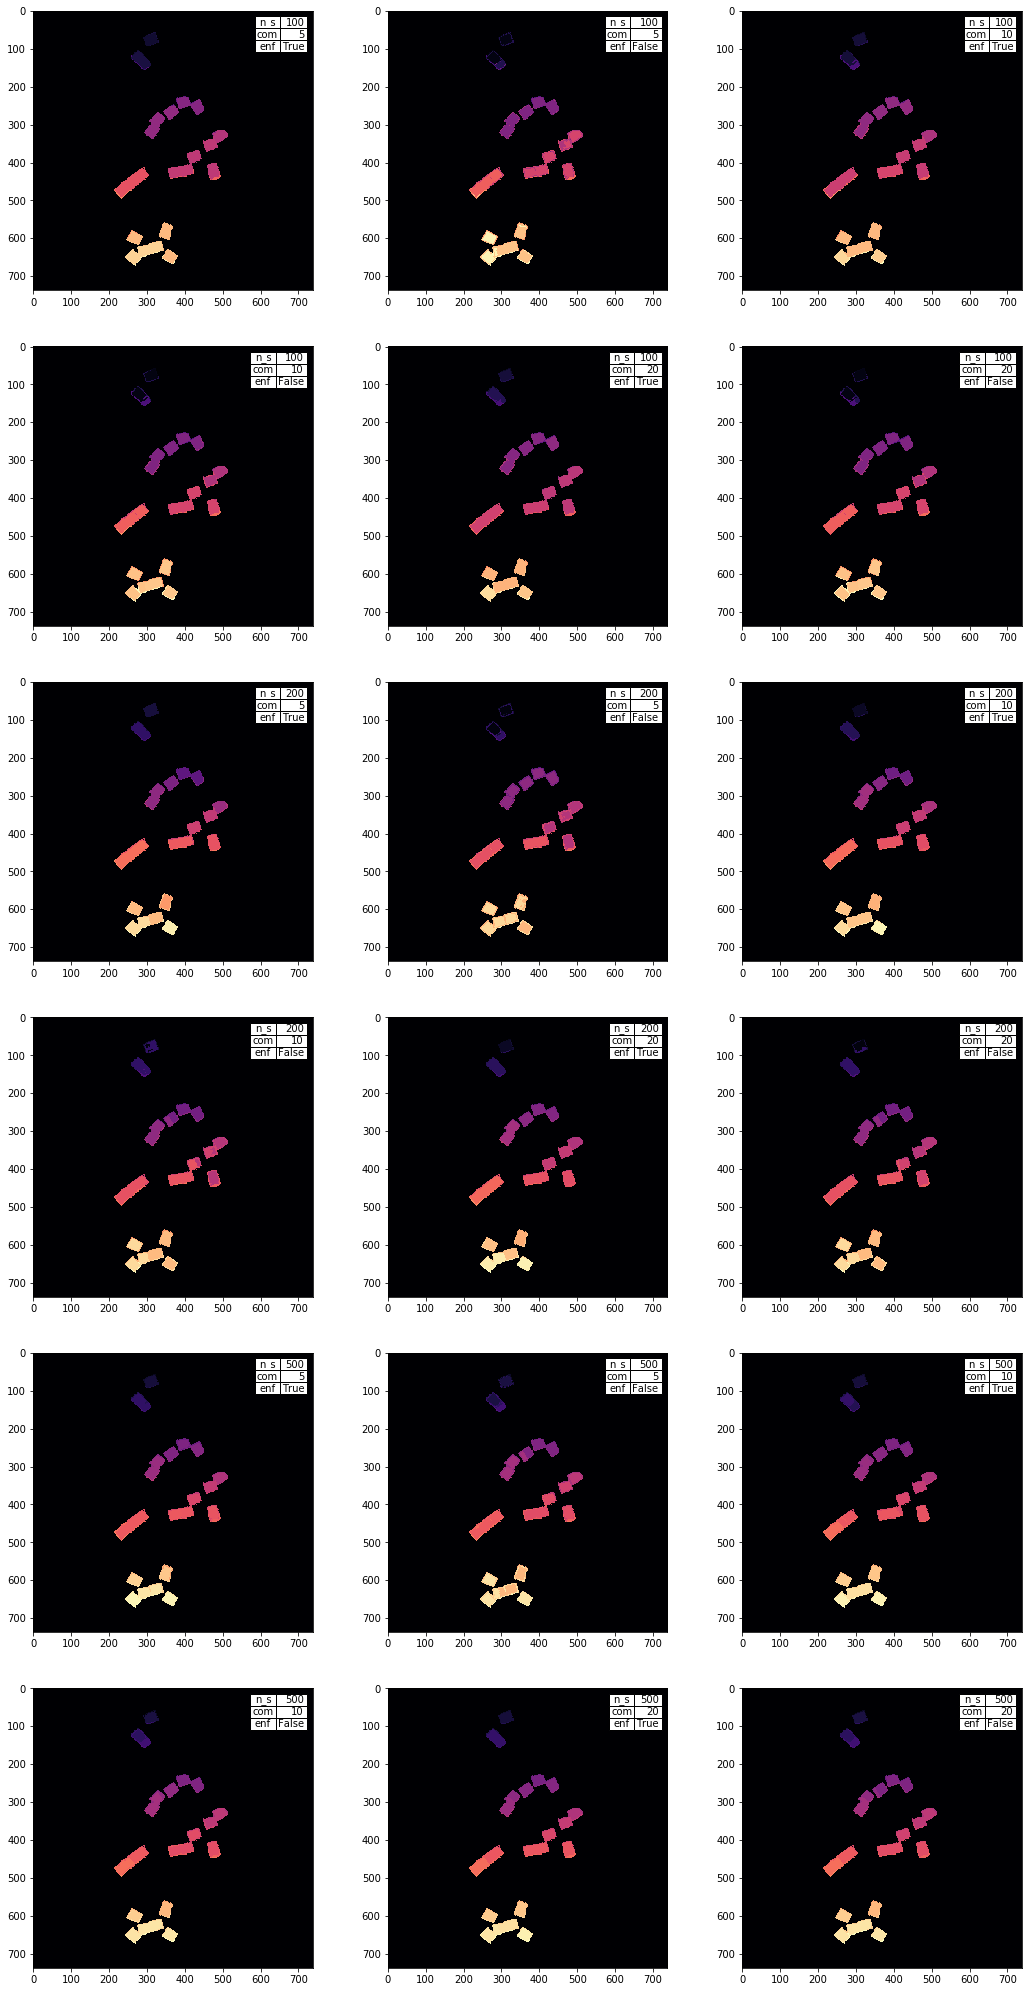

In [16]:
ncols = 3
nrows = int(np.ceil(len(df) / ncols))
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols, 6*nrows))
axes = axes.ravel()

for i, row in df.iterrows():
    
    # Plot detected sections
    labels = np.where(masked_grey, segments[i], 0)
    axes[i].imshow(labels)
    
#     # Plot bounding boxes
#     for j, region in enumerate(regionprops(labels)):
#         y0, x0, y1, x1 = region.bbox
#         p = box(x0, y0, x1, y1)
#         # Annotate sections
#         axes[i].plot(*p.exterior.xy, color='#00ff00', lw=1.5)
#         axes[i].text(x=region.centroid[1], y=region.centroid[0], s=j+1,
#                      color='#00ff00', ha='center', va='center')
    
    # Make table
    vals = row[var_cols].values[:, np.newaxis]
    cols = [col[:3] for col in row[var_cols].index.tolist()]
    tab = axes[i].table(cellText=vals, rowLabels=cols,
                        rowLoc='center', loc='upper right',
                        zorder=1)
    tab.auto_set_column_width(0)

# Remove empty axes from fig
num = axes.size - len(df)  # num of empty axes
[fig.delaxes(ax) for ax in axes[-num:] if num > 0];